In [ ]:
pip install js2py

[*] Reference loaded and recognizer trained.


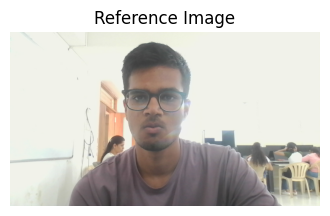

In [ ]:
!pip install --quiet opencv-contrib-python-headless

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# CONFIG
REFERENCE_PATH = "PHOTO.JPG"  # upload this via sidebar or files.upload()
FACE_SIZE = (200, 200)
THRESHOLD = 80  # LBPH: lower confidence = better match

# Load cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def show_image(img_bgr, title=""):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4,4))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

def extract_face_from_bgr(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
    if len(faces) == 0:
        return None
    x, y, w, h = sorted(faces, key=lambda r: r[2]*r[3], reverse=True)[0]
    face = gray[y:y+h, x:x+w]
    face = cv2.resize(face, FACE_SIZE)
    return face

# Load reference
if not os.path.exists(REFERENCE_PATH):
    raise RuntimeError(f"Reference image '{REFERENCE_PATH}' not found. Upload it (name it PHOTO.JPG).")

ref_img = cv2.imread(REFERENCE_PATH)
if ref_img is None:
    raise RuntimeError("Failed to read reference image.")

ref_face = extract_face_from_bgr(ref_img)
if ref_face is None:
    raise RuntimeError("No face detected in reference image. Use a clear frontal photo.")

# Train LBPH
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.train([ref_face], np.array([0], dtype=np.int32))

print("[*] Reference loaded and recognizer trained.")
show_image(ref_img, "Reference Image")


In [ ]:
from IPython.display import HTML, display
from google.colab import output

# Inject JS by rendering as HTML (avoids DataCloneError)
display(HTML("""
<div id="status">Initializing webcam...</div>
<script>
window.captureReady = false;
window.setupVideo = async function() {
  if (!window.videoElem) {
    window.videoElem = document.createElement('video');
    window.videoElem.style.width = '320px';
    window.videoElem.style.height = '240px';
    window.videoElem.autoplay = true;
    window.videoElem.muted = true;
    window.videoElem.playsInline = true;
    document.body.appendChild(window.videoElem);
    try {
      window.stream = await navigator.mediaDevices.getUserMedia({ video: true });
      window.videoElem.srcObject = window.stream;
      await window.videoElem.play();
      window.captureReady = true;
      document.getElementById("status").innerText = "Webcam ready.";
    } catch (e) {
      document.getElementById("status").innerText = "Camera access denied or unavailable.";
      console.error(e);
    }
  }
};

window.captureFace = async function() {
  if (!window.captureReady) {
    await window.setupVideo();
    await new Promise(res => setTimeout(res, 300));
  }
  if (!window.videoElem) {
    return null;
  }
  const canvas = document.createElement('canvas');
  canvas.width = 320;
  canvas.height = 240;
  const ctx = canvas.getContext('2d');
  ctx.drawImage(window.videoElem, 0, 0, canvas.width, canvas.height);
  return canvas.toDataURL('image/jpeg');
};
</script>
"""))

# Now initialize the webcam stream
output.eval_js("setupVideo()")


In [ ]:
import ipywidgets as widgets
import base64
import cv2
import numpy as np
from google.colab import output
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# --- Expect that recognizer, face_cascade, FACE_SIZE, THRESHOLD are in scope from prior cell ---

# Inject JS once via HTML so functions exist globally
display(HTML("""
<div id="status">Initializing webcam...</div>
<script>
window.captureReady = false;
window.setupVideo = async function() {
  if (!window.videoElem) {
    window.videoElem = document.createElement('video');
    window.videoElem.style.width = '320px';
    window.videoElem.style.height = '240px';
    window.videoElem.autoplay = true;
    window.videoElem.muted = true;
    window.videoElem.playsInline = true;
    document.body.appendChild(window.videoElem);
    try {
      window.stream = await navigator.mediaDevices.getUserMedia({ video: true });
      window.videoElem.srcObject = window.stream;
      await window.videoElem.play();
      window.captureReady = true;
      document.getElementById("status").innerText = "Webcam ready.";
    } catch (e) {
      document.getElementById("status").innerText = "Camera access denied or unavailable.";
      console.error(e);
    }
  }
};

window.captureFace = async function() {
  if (!window.captureReady) {
    await window.setupVideo();
    await new Promise(res => setTimeout(res, 300));
  }
  if (!window.videoElem) {
    return null;
  }
  const canvas = document.createElement('canvas');
  canvas.width = 320;
  canvas.height = 240;
  const ctx = canvas.getContext('2d');
  ctx.drawImage(window.videoElem, 0, 0, canvas.width, canvas.height);
  return canvas.toDataURL('image/jpeg');
};
</script>
"""))

# Kick off webcam
_ = output.eval_js("setupVideo()")

# Helper conversions
def data_url_to_bgr(data_url):
    header, encoded = data_url.split(",", 1)
    img_bytes = base64.b64decode(encoded)
    arr = np.frombuffer(img_bytes, np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    return img

def verify_frame(frame_bgr):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
    annotated = frame_bgr.copy()
    if len(faces) == 0:
        return False, None, annotated
    x, y, w, h = sorted(faces, key=lambda r: r[2]*r[3], reverse=True)[0]
    face = gray[y:y+h, x:x+w]
    face_resized = cv2.resize(face, FACE_SIZE)
    label, confidence = recognizer.predict(face_resized)
    match = confidence < THRESHOLD
    text = "MATCH" if match else "NOT MATCH"
    color = (0,255,0) if match else (0,0,255)
    cv2.rectangle(annotated, (x, y), (x+w, y+h), color, 2)
    cv2.putText(annotated, f"{text} ({confidence:.1f})", (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    return match, confidence, annotated

def capture_and_verify():
    try:
        data_url = output.eval_js("captureFace()")
    except Exception as e:
        print("JS call failed:", e)
        return
    if not data_url or not data_url.startswith("data:image"):
        print("Failed to capture image from webcam.")
        return
    frame = data_url_to_bgr(data_url)
    if frame is None:
        print("Decoding failed.")
        return
    match, confidence, annotated = verify_frame(frame)
    if confidence is None:
        print("No face detected in live capture.")
    else:
        status = "✅ MATCH" if match else "❌ NOT MATCH"
        print(f"{status} (confidence: {confidence:.1f}, threshold: {THRESHOLD})")
    # show annotated image
    img_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4,4))
    plt.imshow(img_rgb)
    plt.title("Live Verification")
    plt.axis("off")
    plt.show()

# Button UI
button = widgets.Button(description="Capture & Verify", button_style="info")
out = widgets.Output()

def on_click(b):
    with out:
        out.clear_output()
        capture_and_verify()

button.on_click(on_click)
display(button, out)


Button(button_style='info', description='Capture & Verify', style=ButtonStyle())

Output()